# CMA-ES

In [1]:
import numpy as np
import cma
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
from typing import Callable
from IPython.display import Image

### Optimization Problems

This cell defines three common benchmark functions, Sphere, Rosenbrock, and Rastrigin, used to test optimization algorithms. We also used these functions earlier to evaluate Adam and Momentum.

In [2]:
def sphere(x: np.ndarray) -> float:
    return float(np.sum(x**2))


def rosenbrock(x: np.ndarray) -> float:
    return float(np.sum(100.0 * (x[1:] - x[:-1] ** 2.0) ** 2.0 + (1.0 - x[:-1]) ** 2.0))


def rastrigin(x: np.ndarray) -> float:
    A: float = 10.0
    return float(A * len(x) + np.sum(x**2 - A * np.cos(2 * np.pi * x)))

### Helper functions

Convergence plot and animation.

In [3]:
def plot_convergence(histories: dict[str, list[float]]) -> None:
    plt.figure()
    for name, fitness in histories.items():
        plt.plot(fitness, label=name)
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title("CMA-ES Convergence")
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_convergence_shifted(histories: dict[str, list[float]], start_gen: int = 0) -> None:
    plt.figure()
    for name, fitness in histories.items():
        if start_gen < len(fitness):
            plt.plot(range(start_gen, len(fitness)), fitness[start_gen:], label=name)
        else:
            print(f"Warning: {name} has fewer generations than start_gen={start_gen}")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.title(f"CMA-ES Convergence (from generation {start_gen})")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    
def animate_distribution(
    func: Callable[[np.ndarray], float],
    mu_history: list[np.ndarray],
    cov_history: list[np.ndarray],
    bounds: tuple[float, float] = (-5, 5),
    frames: int = 50,
    filename: str = "cma_es_animation.mp4",
) -> None:
    x = np.linspace(bounds[0], bounds[1], 200)
    y = np.linspace(bounds[0], bounds[1], 200)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T
    Z = np.array([func(pt) for pt in coords]).reshape(X.shape)

    fig, ax = plt.subplots()
    levels = np.logspace(np.log10(Z.min() + 1e-6), np.log10(Z.max()), 30)

    def update(frame_index: int) -> None:
        ax.clear()
        ax.contour(X, Y, Z, levels=levels, cmap="viridis")
        mu = mu_history[frame_index]
        cov = cov_history[frame_index]
        vals, vecs = np.linalg.eigh(cov)
        angle = float(np.degrees(np.arctan2(vecs[0, 1], vecs[0, 0])))
        width, height = 2 * np.sqrt(vals)
        ellipse = Ellipse(
            xy=mu,
            width=width,
            height=height,
            angle=angle,
            edgecolor="red",
            facecolor="none",
            lw=2,
        )
        ax.add_patch(ellipse)
        ax.plot(mu[0], mu[1], "ro")
        ax.set_title(f"Generation {frame_index}")
        ax.set_xlim(bounds)
        ax.set_ylim(bounds)

    anim = FuncAnimation(fig, update, frames=min(frames, len(mu_history)), interval=200)
    anim.save(filename, writer="ffmpeg")
    print(f"Animation saved to {filename}")

### Running CMA-ES

In [4]:
from dataclasses import dataclass

@dataclass
class CMAESResult:
    best_fitness: list[float]
    mean_history: list[np.ndarray]
    cov_history: list[np.ndarray]
    sigma_history: list[float]

def run_cma_es(
    func: Callable[[np.ndarray], float],
    x0: np.ndarray,
    sigma0: float,
    max_iterations: int | None = None,
    eval_budget: int | None = None,
) -> CMAESResult:
    
    es = cma.CMAEvolutionStrategy(x0.tolist(), sigma0)

    best_fitness = []
    mean_history = []
    cov_history = []
    sigma_history = []

    evals_used = 0
    iterations = 0

    while not es.stop():
        if max_iterations is not None and iterations >= max_iterations:
            break
        if eval_budget is not None and evals_used >= eval_budget:
            break

        solutions = es.ask()
        fitnesses = [func(np.array(x)) for x in solutions]
        es.tell(solutions, fitnesses)

        evals_used += len(solutions)
        iterations += 1

        best_fitness.append(min(fitnesses))
        mean_history.append(np.copy(es.mean))
        cov_history.append(np.copy(es.C))
        sigma_history.append(es.sigma)

    return CMAESResult(
        best_fitness=best_fitness,
        mean_history=mean_history,
        cov_history=cov_history,
        sigma_history=sigma_history
    )

### Ex. 1: Impact of the Starting Point
1.	Choose Rosenbrock in 2D.
2.	Run CMA-ES from at least five widely separated initial means (e.g., [-4,-4], [-1,3], [5,5]).
3.	Plot convergence curves and report:
- best fitness vs. generation,
- total evaluations to reach $f(x)\lt10^{-8}$ (or termination).
4.	Briefly discuss sensitivity to the start point. Prepare GIFs for two different starting points.

Hint: use `sigma0 = 0.5` and `max_iter = 250`.

In [5]:
starting_points = [
    np.array([-4.0, -4.0]),
    np.array([-1.0, 3.0]),
    np.array([5.0, 5.0]),
    np.array([2.0, -3.0]),
    np.array([-3.0, 2.0])
]

sigma0 = 0.5
max_iter = 250

In [20]:
results = {}
histories = {}
evaluations_to_target = {}
target_fitness = 1e-8

for idx, x0 in enumerate(starting_points):
    result = run_cma_es(rosenbrock, x0, sigma0, max_iterations=max_iter)
    name = f"start_{idx+1}_{x0.tolist()}"
    histories[name] = result.best_fitness
    results[name] = result

    try:
        evals = next(i for i, fit in enumerate(result.best_fitness) if fit < target_fitness)
    except StopIteration:
        evals = len(result.best_fitness)
    evaluations_to_target[name] = evals

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=526230, Fri May 16 17:55:27 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=479820, Fri May 16 17:55:27 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=476099, Fri May 16 17:55:27 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=523852, Fri May 16 17:55:27 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=532736, Fri May 16 17:55:27 2025)


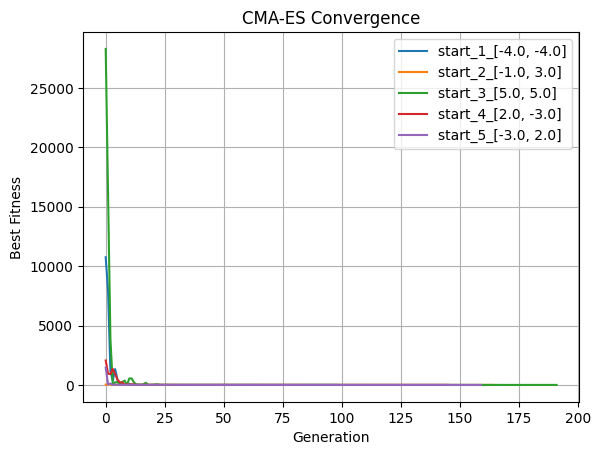

In [7]:
plot_convergence(histories)

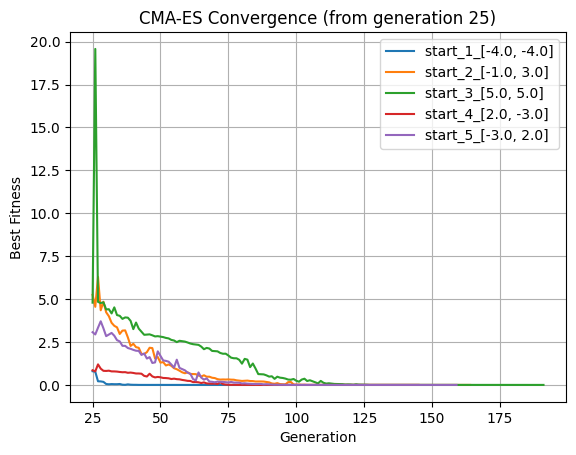

In [8]:
plot_convergence_shifted(histories, 25)

In [9]:
for name, evals in evaluations_to_target.items():
    print(f"{name}: evaluations to reach target = {evals}")

start_1_[-4.0, -4.0]: evaluations to reach target = 66
start_2_[-1.0, 3.0]: evaluations to reach target = 122
start_3_[5.0, 5.0]: evaluations to reach target = 154
start_4_[2.0, -3.0]: evaluations to reach target = 106
start_5_[-3.0, 2.0]: evaluations to reach target = 126


In [31]:
results.keys()

dict_keys(['start_1_[-4.0, -4.0]', 'start_2_[-1.0, 3.0]', 'start_3_[5.0, 5.0]', 'start_4_[2.0, -3.0]', 'start_5_[-3.0, 2.0]'])

In [34]:
def animate_by_name(results: dict[str: CMAESResult], name: str):
    animate_distribution(
    func=rosenbrock,
    mu_history=results[name].mean_history,
    cov_history=results[name].cov_history,
    bounds=(-5, 5),
    frames=50,
    filename=f"rosenbrock_{name}.gif"
)

In [ ]:
animate_by_name(results, "start_3_[5.0, 5.0]")

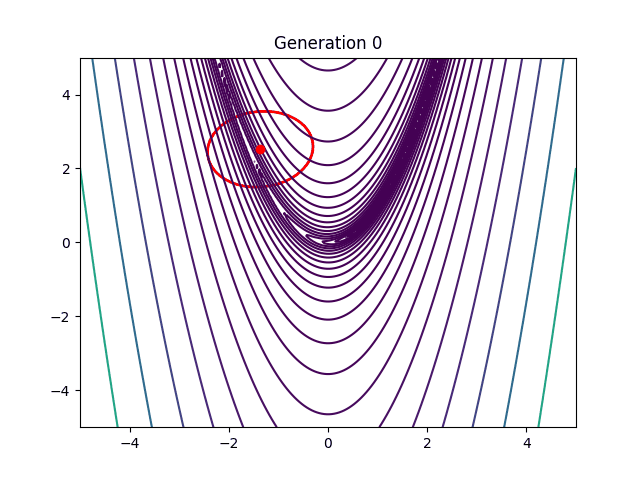

In [38]:
Image(filename="rosenbrock_start_2_[-1.0, 3.0].gif")

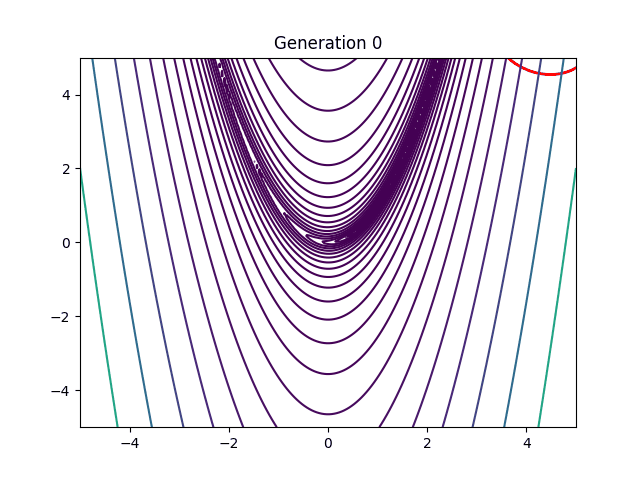

In [39]:
Image(filename="rosenbrock_start_3_[5.0, 5.0].gif")

In [ ]:
animate_by_name(results, "start_2_[-1.0, 3.0]")

A good starting point, e.g. [-4, -4], allows us to find the minimum faster. The point [5, 5] is the hardest one, as it required more than twice as many evaluations as [-4, -4].

### Ex. 2: Effect of the Initial Global Step‐Size $\sigma_0$
1. Use [2,2] at starting point on the Rastrigin function.
2. Test $\sigma_0\in\{0.1,\,0.5,\,1,\,2,\,5\}$.
3. Record and plot
- final fitness after a fixed budget (e.g. 1000 evals)
- evolution of es.sigma over time (log scale).
4. Explain why too-small and too-large $\sigma_0$ hurt performance, relating findings to the adaptation rule.

In [15]:
x0 = np.array([2.0, 2.0])
sigmas = [0.1, 0.5, 1.0, 2.0, 5.0]
budget = 1000

fitness_results = {}
sigma_evolution = {}
final_fitnesses = {}

for sigma0 in sigmas:
    result = run_cma_es(rastrigin, x0, sigma0, eval_budget=budget)
    label = f"sigma0={sigma0}"
    fitness_results[label] = result.best_fitness
    sigma_evolution[label] = result.sigma_history
    final_fitnesses[label] = result.best_fitness[-1]

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=505311, Fri May 16 17:49:07 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=535429, Fri May 16 17:49:07 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=496437, Fri May 16 17:49:07 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=527963, Fri May 16 17:49:07 2025)
(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=520866, Fri May 16 17:49:07 2025)


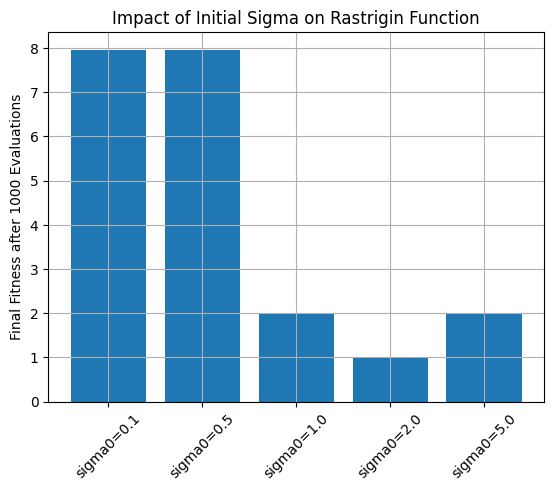

In [16]:
plt.figure()
plt.bar(final_fitnesses.keys(), final_fitnesses.values())
plt.ylabel("Final Fitness after 1000 Evaluations")
plt.title("Impact of Initial Sigma on Rastrigin Function")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

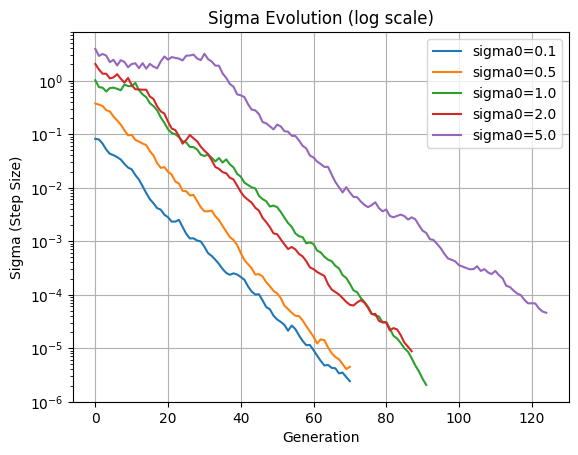

In [17]:
plt.figure()
for label, sigma_hist in sigma_evolution.items():
    plt.plot(sigma_hist, label=label)
plt.yscale("log")
plt.xlabel("Generation")
plt.ylabel("Sigma (Step Size)")
plt.title("Sigma Evolution (log scale)")
plt.legend()
plt.grid(True)
plt.show()

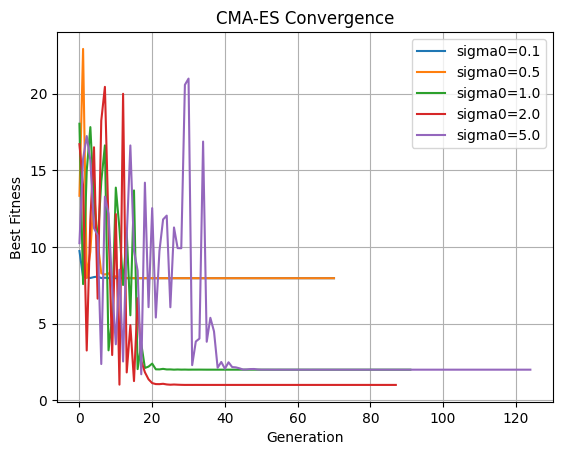

In [18]:
plot_convergence(fitness_results)

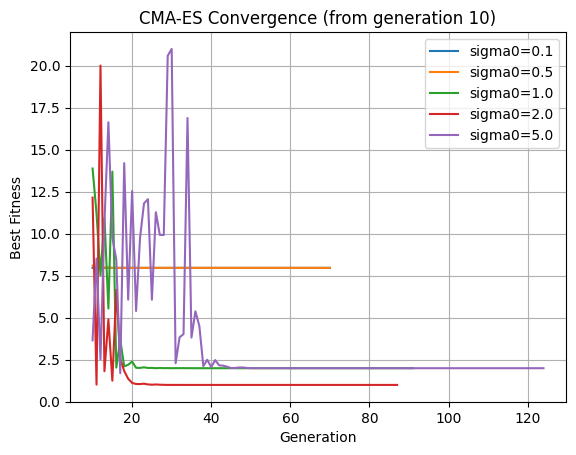

In [19]:
plot_convergence_shifted(fitness_results, 10)

To small sigma easily gets stuck in local minima. Too large sigma jumps wildly wasting evaluations.

### Ex. 3: Visualising the Covariance Matrix Adaptation
1. On Sphere in 2D, log es.C every 5 generations.
2. Use the provided `animate_distribution` to produce a GIF showing the shrinking and rotation of the sampling ellipse.
3. Submit the animation and two short observations about what the animation reveals regarding step-size vs. shape adaptation.

In [37]:
x0 = np.array([2.0, 2.0])
sigma0 = 5.0
max_iter = 80

result = run_cma_es(sphere, x0, sigma0, max_iterations=max_iter)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=519150, Fri May 16 18:27:11 2025)


In [ ]:
animate_distribution(
    func=sphere,
    mu_history=result.mean_history,
    cov_history=result.cov_history,
    bounds=(-3, 3),
    frames=len(result.cov_history),
    filename=f"sphere_cov_adaptation_sigma{sigma0}_max_iter_{max_iter}.gif"
)

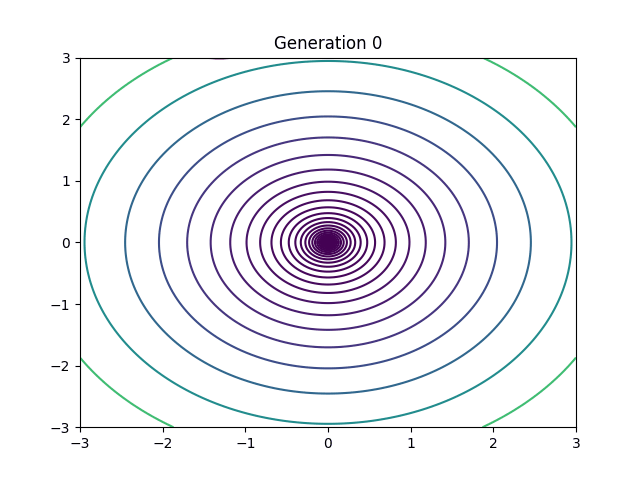

In [40]:
Image(filename="sphere_cov_adaptation_sigma5.0_max_iter_80.gif")

In [28]:
x0 = np.array([2.0, 2.0])
sigma0 = 1.5
max_iter = 80

result = run_cma_es(sphere, x0, sigma0, max_iterations=max_iter)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=562479, Fri May 16 18:21:05 2025)


In [ ]:
animate_distribution(
    func=sphere,
    mu_history=result.mean_history,
    cov_history=result.cov_history,
    bounds=(-3, 3),
    frames=len(result.cov_history),
    filename=f"sphere_cov_adaptation_sigma{sigma0}_max_iter_{max_iter}.gif"
)

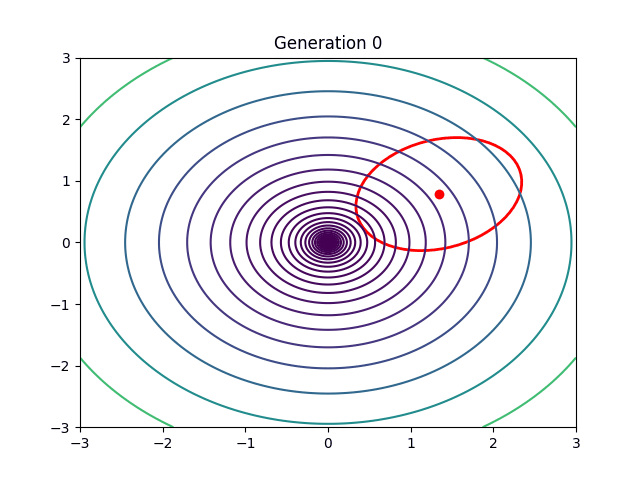

In [30]:
Image(filename="sphere_cov_adaptation_sigma1.5_max_iter_80.gif")

In [31]:
x0 = np.array([2.0, 2.0])
sigma0 = 0.5
max_iter = 80

result = run_cma_es(sphere, x0, sigma0, max_iterations=max_iter)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=464422, Fri May 16 18:21:50 2025)


In [ ]:
animate_distribution(
    func=sphere,
    mu_history=result.mean_history,
    cov_history=result.cov_history,
    bounds=(-3, 3),
    frames=len(result.cov_history),
    filename=f"sphere_cov_adaptation_sigma{sigma0}_max_iter_{max_iter}.gif"
)

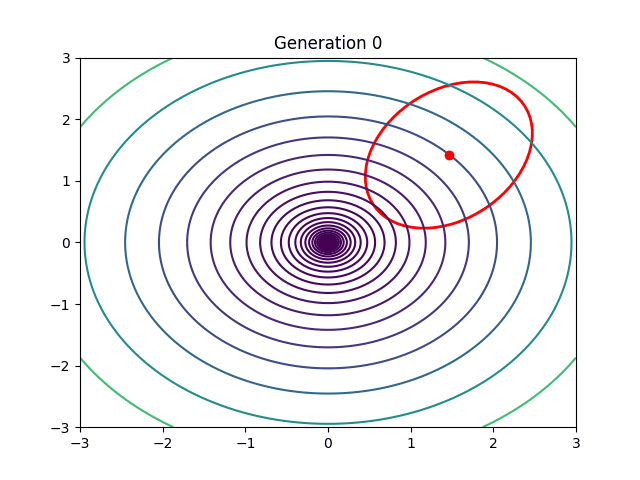

In [33]:
Image(filename="sphere_cov_adaptation_sigma0.5_max_iter_80.gif")

In [34]:
x0 = np.array([2.0, 2.0])
sigma0 = 0.1
max_iter = 80

result = run_cma_es(sphere, x0, sigma0, max_iterations=max_iter)

(3_w,6)-aCMA-ES (mu_w=2.0,w_1=63%) in dimension 2 (seed=565304, Fri May 16 18:25:41 2025)


In [ ]:
animate_distribution(
    func=sphere,
    mu_history=result.mean_history,
    cov_history=result.cov_history,
    bounds=(-3, 3),
    frames=len(result.cov_history),
    filename=f"sphere_cov_adaptation_sigma{sigma0}_max_iter_{max_iter}.gif"
)

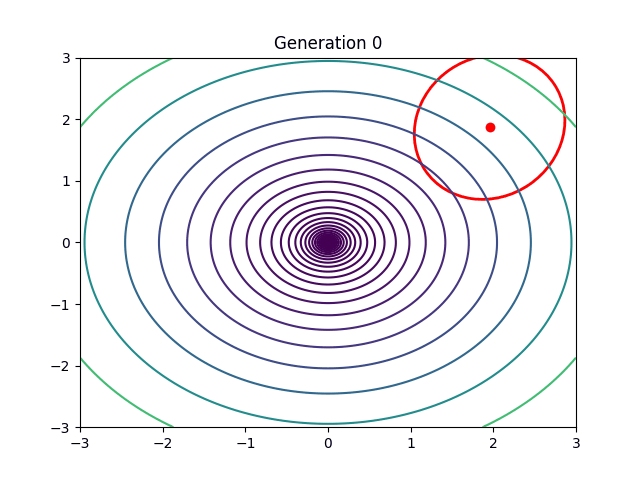

In [36]:
Image(filename="sphere_cov_adaptation_sigma0.1_max_iter_80.gif")

I logged covariance every iteration, because, in my opinion, that way it is easier to notice patterns. \
The sampling ellipse shrinks over time, showing that the step-size σ is decreasing as the optimizer approaches the minimum. \
Despite the Sphere function being symmetric, the ellipse becomes elongated and rotates during optimization. This shows that CMA-ES performs shape adaptation based on the successful search directions, even when the problem itself does not require it.